In [1]:
import numpy as np
np.set_printoptions(suppress=True)

# Will also use just-in-time (JIT) compilation via numba for speeding up simulations
from numba import njit


import bayesflow as bf

2025-07-13 08:48:36.068449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752396516.082697   41558 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752396516.086595   41558 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-13 08:48:36.102574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-13 08:48:38.472251: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

## Introduction

Modeling cognitive processes using both behavioral and neural data requires integrative neurocognitive models that jointly describe decision-making processes and neural dynamics. Traditional approaches, such as sequential sampling models (SSMs) like drift-diffusion models (DDMs), have successfully linked behavioral responses with underlying cognitive parameters. However, extending these models to simultaneously account for neural signals, such as EEG-derived event-related potentials (ERPs), presents significant challenges [1].

A key limitation of standard Bayesian inference methods, such as Markov chain Monte Carlo (MCMC), is their computational inefficiency when applied to single-trial data, where each trial introduces new latent variables and dependencies between neural and behavioral measures. This complexity makes traditional likelihood-based inference impractical.

Amortized Bayesian inference (ABI), as implemented in `BayesFlow` provides an efficient alternative by leveraging deep learning to approximate posterior distributions across many possible model configurations. By training on simulated data, our networks quickly learn to map observed EEG and behavioral measures directly to posterior distributions of cognitive parameters, avoiding the need for case-by-case inference. This approach not only accelerates parameter estimation but also enables robust model validation and generalization across datasets.

[1] Ghaderi-Kangavari, A., Rad, J. A., & Nunez, M. D. (2023). A general integrative neurocognitive modeling framework to jointly describe EEG and decision-making on single trials. *Computational Brain & Behavior, 6(3)*, 317-376.

## Joint Neurocognitive Model

For this demonstration, we will focus on model $\mathcal{M}_{1c}$ from Ghaderi-Kangavari et al. (2023), which defines the following generative process for behavavioral data $(x_n, c_n)$ and neural (EEG) data $(z_n, \tau_n)$:
$$
\begin{align*}
    (x_n, c_n) &\sim \text{DDM}(\alpha, \tau_n, \delta, \beta)\\
    z_n &\sim \mathcal{TN}(\tau_n - \tau_m, \sigma^2, a, b)\\
    \tau_n &\sim \mathcal{U}(f(\tau_e,  s_{\tau}), f(\tau_e,  -s_{\tau}))
\end{align*}
$$

The model has seven parameters in total, $\theta = (\alpha, \delta, \beta, \tau_e, \tau_m, s_{\tau}, \sigma)$, indexing different neurcognitive aspects of the decision process. See Ghaderi-Kangavari et al. (2023) for more details.

### Defining the Prior

In [2]:
def draw_prior():
    """Draws samples from the prior distributions of m1c, as described in Ghaderi-Kangavari et al. (2023)"""

    prior_draws = np.random.uniform(
        low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
        high=(3.0, 2.0, 0.9, 0.4, 0.6, 0.1, 0.1)
    )

    prior_draws = {
        "drift": prior_draws[0],
        "boundary": prior_draws[1],
        "beta": prior_draws[2],
        "mu_tau_e": prior_draws[3],
        "tau_m": prior_draws[4],
        "sigma": prior_draws[5],
        "varsigma": prior_draws[6]
    }

    return prior_draws

### Definining the Simulator

We use `numba` s just-in-time (JIT) compiler to speed up the for loops of the simulators.

In [3]:
@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, s=1.0, dt=5e-3):
    """Simulates a trial from the joint diffusion model m1b."""

    c = np.sqrt(dt) * s
    n_steps = 0.0
    evidence = boundary * beta

    while evidence > 0 and evidence < boundary:
        evidence += drift * dt + c * np.random.normal()
        n_steps += 1.0

    z = 0
    while True:
        # visual encoding
        tau_encoding = mu_tau_e + np.random.uniform(-0.5 * np.sqrt(12) * varsigma, 0.5 * np.sqrt(12) * varsigma)
        z = np.random.normal(tau_encoding, sigma)
        if z > 0 and z < 0.5:
            break

    rt = n_steps * dt + tau_encoding + tau_m

    if evidence >= boundary:
        return (rt, 1.0, z)
    return (rt, 0.0, z)


def simulate_trials(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, num_trials=120):
    """Simulates a diffusion process for trials."""

    data = np.empty((num_trials, 3))
    for i in range(num_trials):
        data[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma)
    return dict(data=data)

### Connecting Prior and Simulator

For now, we will use a fixed number of trials. In practice, different data sets (e.g., participants) will have different numbers of valid trials. We will demonstrate the application to a variable number of trials further down the line.

**Note**: You can also completely bypass the BayesFlow simulation utilities. As long as your simulator returns dictionaries and you define a suitable adapter (see section **Custom Adapter**), you should be good to go.

In [4]:
simulator = bf.make_simulator([draw_prior, simulate_trials])

In [5]:
# Always a good idea to test the fidelity of the outputs
test_sims = simulator.sample(2)
for k, v in test_sims.items():
    print(f"Output {k} has a shape of {v.shape}")

Output drift has a shape of (2, 1)
Output boundary has a shape of (2, 1)
Output beta has a shape of (2, 1)
Output mu_tau_e has a shape of (2, 1)
Output tau_m has a shape of (2, 1)
Output sigma has a shape of (2, 1)
Output varsigma has a shape of (2, 1)
Output data has a shape of (2, 120, 3)


## Offline Dataset
To demonstrate the utility of ABI, we will use a rather small set of offline simulations. Simulations are usually fast for cognitive modeling, so we recommend using online training in your applications.

In [6]:
offline_sims = simulator.sample(6000)

validation_sims = simulator.sample(200)

## Workflow Components

In [7]:
# Training hyperparameters
batch_size = 32
# Increase the number of epochs for better performance (e.g. to 100)
epochs = 20

# The set transformer will compress data from N trials of shape (N, 3) into a vector of shape (16,)
summary_network = bf.networks.SetTransformer(summary_dim=16)

# We use the good old coupling flow. You can try some of the latest generative architectures as well (e.g., FlowMatching)
inference_network = bf.networks.CouplingFlow()

The quickest way to create a workflow is demonstrated below. For more complex pipelines, you should create a data adapter explicitly, as demonstrated below.

In practice, you should also save the networks using the `checkpoint_filepath` and `checkpoint_name` keyword arguments. The approximator can later ba loaded as
- If you want to use the workflow functionality: `workflow.approximator = keras.saving.load(checkpoint_filepath/checkpoint_name.keras)`
- If you just want the standalone pre-trained approximator: `approximator = keras.saving.load(checkpoint_filepath/checkpoint_name.keras)`

In [8]:
workflow = bf.BasicWorkflow(
    simulator=simulator, 
    inference_network=inference_network, 
    summary_network=summary_network,
    inference_variables=["drift", "boundary", "beta", "mu_tau_e", "tau_m", "sigma", "varsigma"],
    inference_conditions=None,
    summary_variables=["data"]
)

We can inspect the default adapter like so:

In [9]:
workflow.adapter

Adapter([0: ConvertDType -> 1: Concatenate(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma'] -> 'inference_variables') -> 2: Concatenate(['data'] -> 'summary_variables')])

Training then proceeds as follows. Without a GPU, training should take around 10 minutes; using a GPU, you can get down to less than a minute.

In [10]:
history = workflow.fit_offline(
    offline_sims,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_sims,
    verbose=2,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
188/188 - 53s - 281ms/step - loss: 7.8519 - val_loss: 5.8041
Epoch 2/20
188/188 - 30s - 158ms/step - loss: 4.5390 - val_loss: 2.5351
Epoch 3/20
188/188 - 30s - 159ms/step - loss: 2.6700 - val_loss: 2.0294
Epoch 4/20
188/188 - 31s - 164ms/step - loss: 2.0685 - val_loss: 1.8672
Epoch 5/20
188/188 - 29s - 152ms/step - loss: 1.8300 - val_loss: 1.5873
Epoch 6/20
188/188 - 30s - 158ms/step - loss: 1.5136 - val_loss: 1.1278
Epoch 7/20
188/188 - 28s - 151ms/step - loss: 1.3078 - val_loss: 1.0039
Epoch 8/20
188/188 - 28s - 151ms/step - loss: 1.1343 - val_loss: 1.4365
Epoch 9/20
188/188 - 29s - 157ms/step - loss: 0.9476 - val_loss: 0.8202
Epoch 10/20
188/188 - 29s - 153ms/step - loss: 0.8167 - val_loss: 0.6834
Epoch 11/20
188/188 - 29s - 154ms/step - loss: 0.5641 - val_loss: 0.2522
Epoch 12/20
188/188 - 29s - 153ms/step - loss: 0.4931 - val_loss: 0.4941
Epoch 13/20
188/188 - 28s - 151ms/step - loss: 0.3016 - val_loss: 0.3768
Epoch 14/20
188/188 - 28s - 149ms/step - loss: 0.1262 - val_

## In Silico Validation

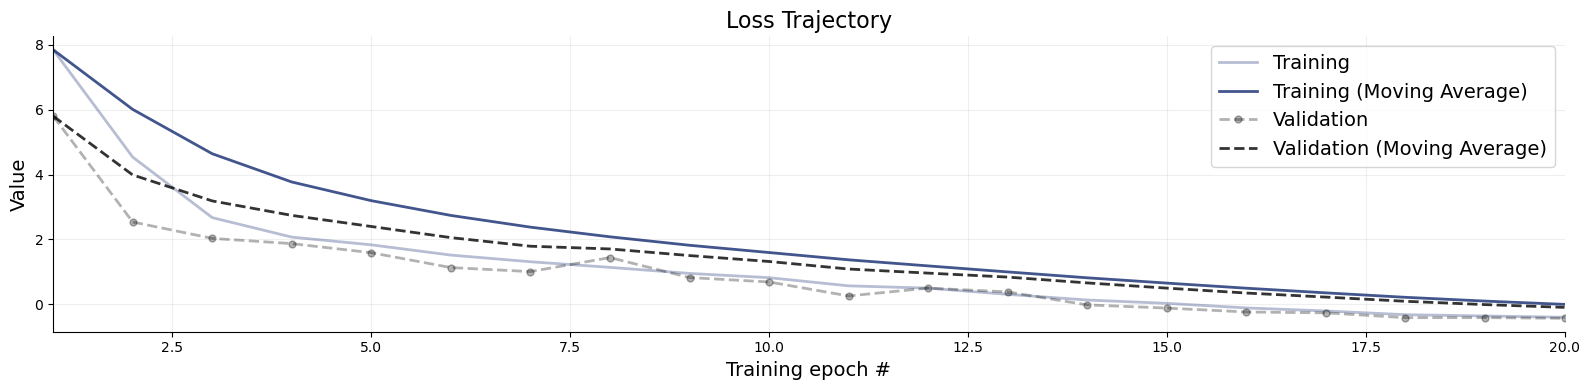

In [11]:
f = bf.diagnostics.plots.loss(history)

### Visual Diagnostics
You can easily plot all checks of computational faithfulness pertaining to a principled Bayesian workflow [2]:

[2] Schad, D. J., Betancourt, M., & Vasishth, S. (2021). Toward a principled Bayesian workflow in cognitive science. *Psychological methods, 26(1)*, 103.

{'losses': <Figure size 1500x300 with 1 Axes>,
 'recovery': <Figure size 1500x600 with 7 Axes>,
 'calibration_ecdf': <Figure size 1500x600 with 7 Axes>,
 'z_score_contraction': <Figure size 1500x600 with 7 Axes>}

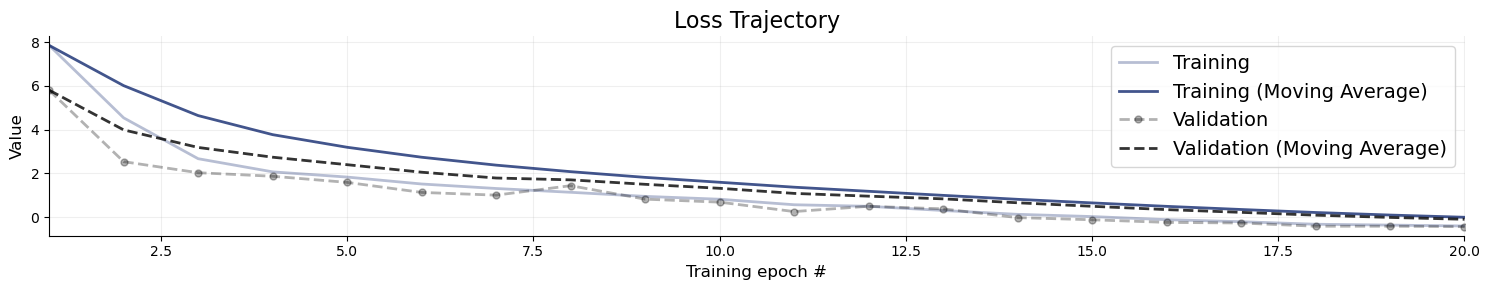

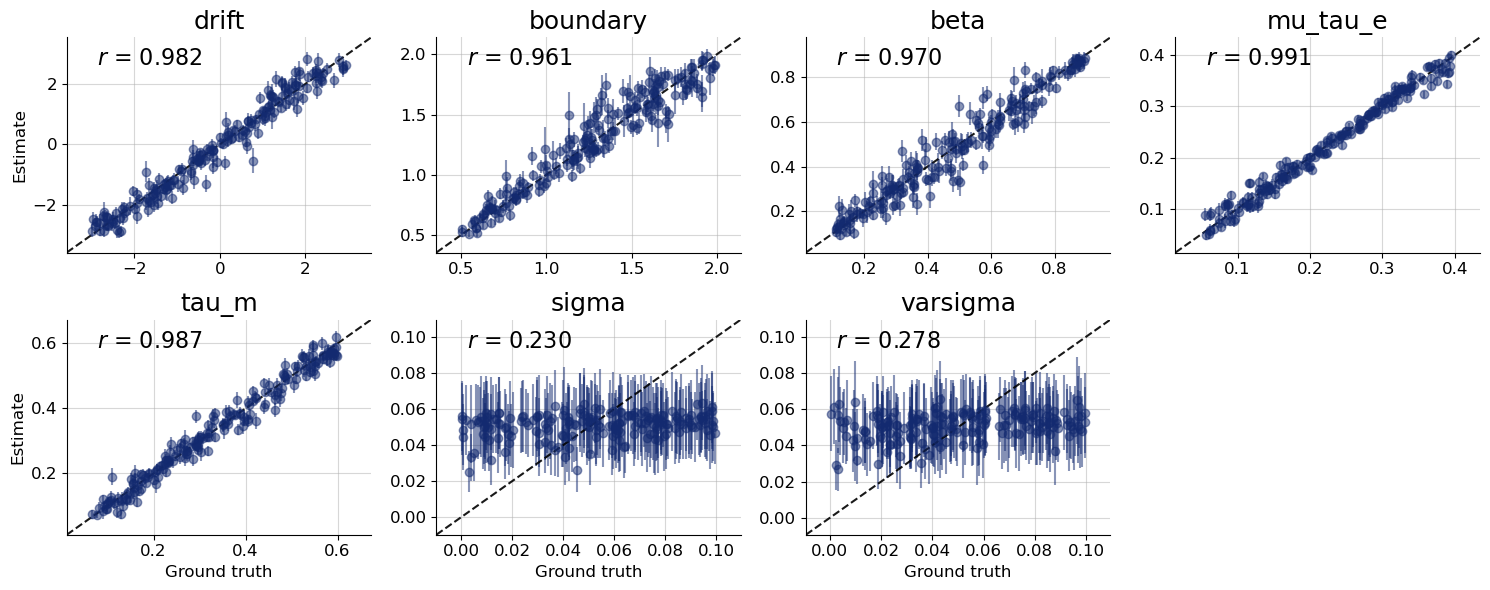

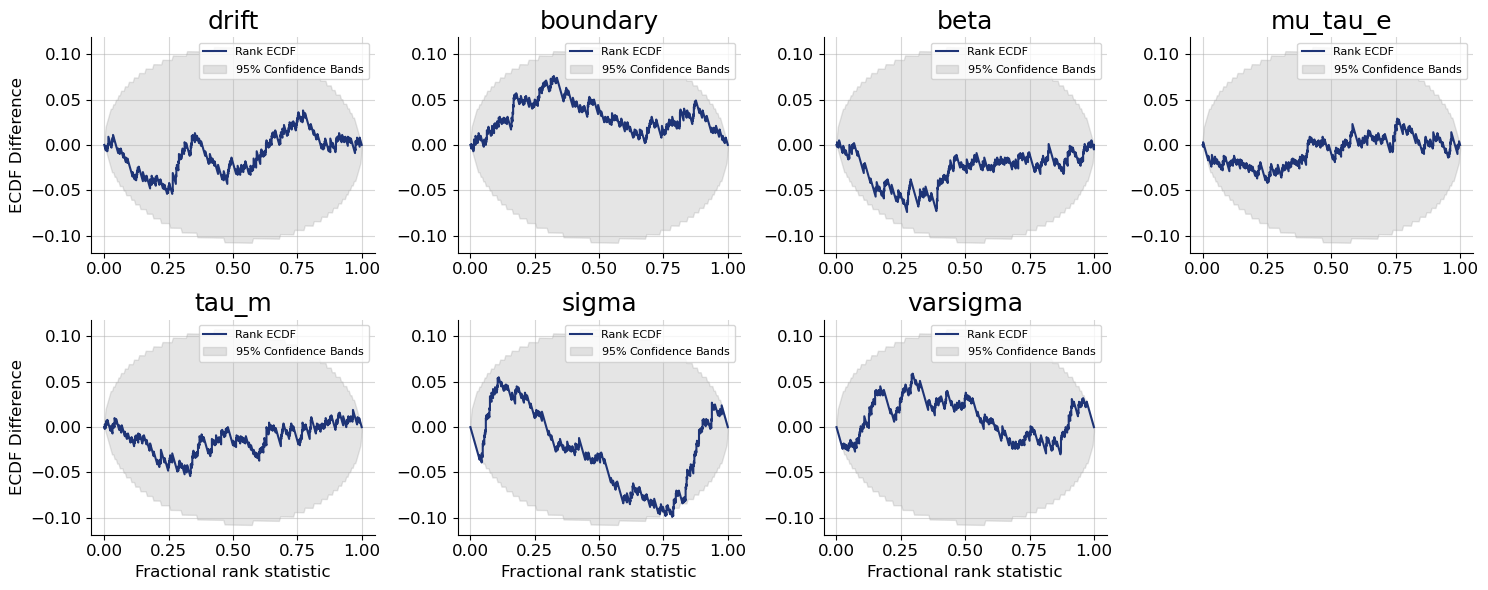

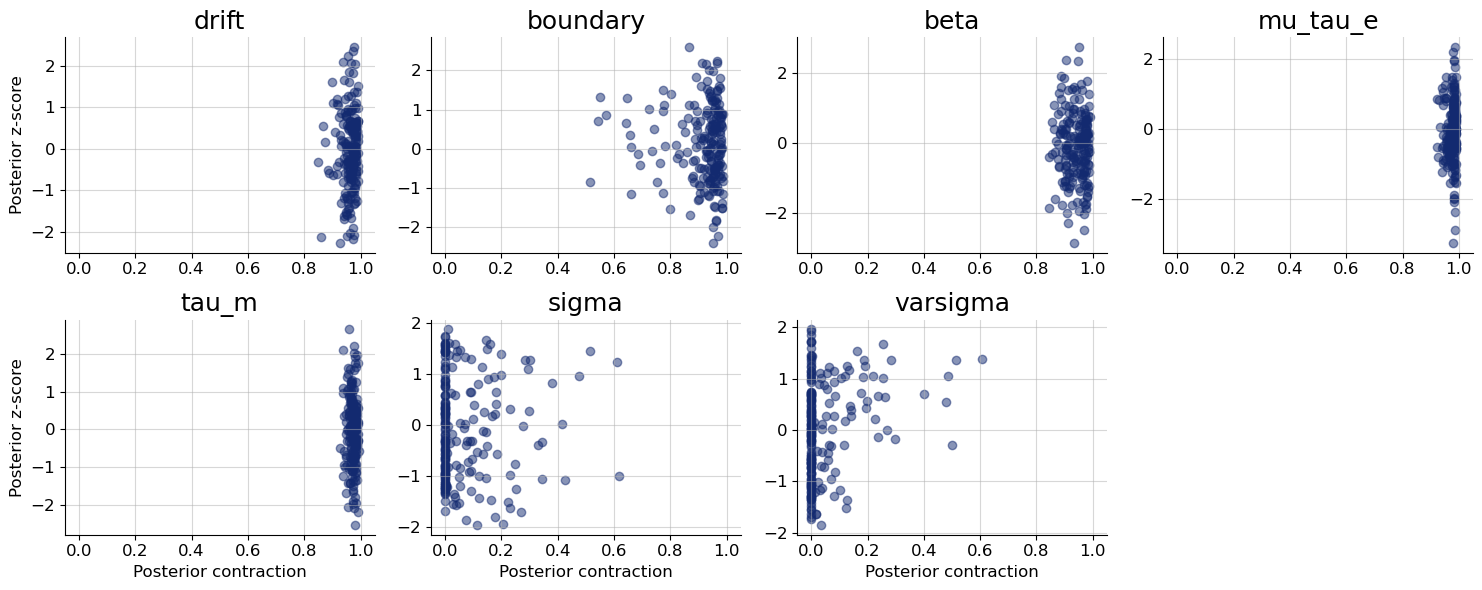

In [12]:
fig = workflow.plot_default_diagnostics(
    test_data=validation_sims, 
    num_samples=500,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 6), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 6), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 6), "label_fontsize": 12}  
)
fig

In [13]:
table = workflow.compute_default_diagnostics(validation_sims, num_samples=500)
table

,drift,boundary,beta,mu_tau_e,tau_m,sigma,varsigma
NRMSE,0.075900,0.111066,0.101675,0.058362,0.068680,0.406021,0.391235
Posterior Contraction,0.967824,0.946947,0.951313,0.980855,0.973531,0.000000,0.000000
Calibration Error,0.018289,0.021579,0.020395,0.022895,0.017763,0.045526,0.035263


## Variable Number of Trials

We now allow for a variable number of trials.

*Note: the JAX backend has to re-run its optimizations for each number of trials, making training quite slow. TensorFlow can handle the varying number of trials and is therefore the recommended backend for this setting.*

In [14]:
def random_num_trials():
    return dict(num_trials=np.random.randint(low=10, high=200+1))

In [15]:
var_trials_simulator = bf.make_simulator([draw_prior, simulate_trials], meta_fn=random_num_trials)

In [16]:
# Always a good idea to test the fidelity of the outputs
test_sims = var_trials_simulator.sample(2)
for k, v in test_sims.items():
    print(f"Output {k} has a shape of {v.shape}" if type(v) is not int else f"Number of trials: {v}")

Number of trials: 194
Output drift has a shape of (2, 1)
Output boundary has a shape of (2, 1)
Output beta has a shape of (2, 1)
Output mu_tau_e has a shape of (2, 1)
Output tau_m has a shape of (2, 1)
Output sigma has a shape of (2, 1)
Output varsigma has a shape of (2, 1)
Output data has a shape of (2, 194, 3)


### Custom Adapter

The custom adapter now separates all simulator outputs into three categories:
1. `inference_variables` - the targets of inference;
2. `summary_variables` - the conditioning variables that will be first summarized by the summary network;
3. `inference_conditions` - the conditioning variables that will bypass the summary network and directly inform the inference network.

In [17]:
adapter = (
    bf.Adapter()
    .sqrt("num_trials")
    .broadcast("num_trials", to="data", exclude=(1, 2), squeeze=-1)
    .concatenate(["drift", "boundary", "beta", "mu_tau_e", "tau_m", "sigma", "varsigma"], into="inference_variables")
    .rename("data", "summary_variables")
    .rename("num_trials", "inference_conditions")
)

Use a larger network for generalizing across different numbers of observations.

In [18]:
# Training hyperparameters
batch_size = 32
# Increase the number of epochs for better performance (e.g., to 200)
epochs = 20

# The set transformer will compress data from N trials of shape (N, 3) into a vector of shape (16,)
summary_network = bf.networks.SetTransformer(summary_dim=16, embed_dims=(128, 128), num_seeds=3)

# We use the good old coupling flow. You can try some of the latest generative architectures as well (e.g., FlowMatching)
inference_network = bf.networks.CouplingFlow()

In [19]:
var_trials_workflow = bf.BasicWorkflow(
    simulator=var_trials_simulator,
    inference_network=inference_network, 
    summary_network=summary_network,
    initial_learning_rate=1e-4,
    adapter=adapter,
    inference_variables=["drift", "boundary", "beta", "mu_tau_e", "tau_m", "sigma", "varsigma"],
    inference_conditions=None,
    summary_variables=["data"],
)

We will now demonstrate online training, since offline training with variable number of trials can be tricky (it would require simulating with maximum number of trials and then taking subsets).

In [20]:
history2 = var_trials_workflow.fit_online(epochs=epochs, num_batches_per_epoch=batch_size)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - loss: 9.8274 
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - loss: 8.9477 
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - loss: 8.0725
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - loss: 7.3130 
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - loss: 6.8796 
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - loss: 6.4235 
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - loss: 6.4090 
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - loss: 6.3657 
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - loss: 6.2210 
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - loss: 5.9977 
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - loss: 5.9510 
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - loss: 5.6591 
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 5.5640
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - loss: 5.1299 
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 3

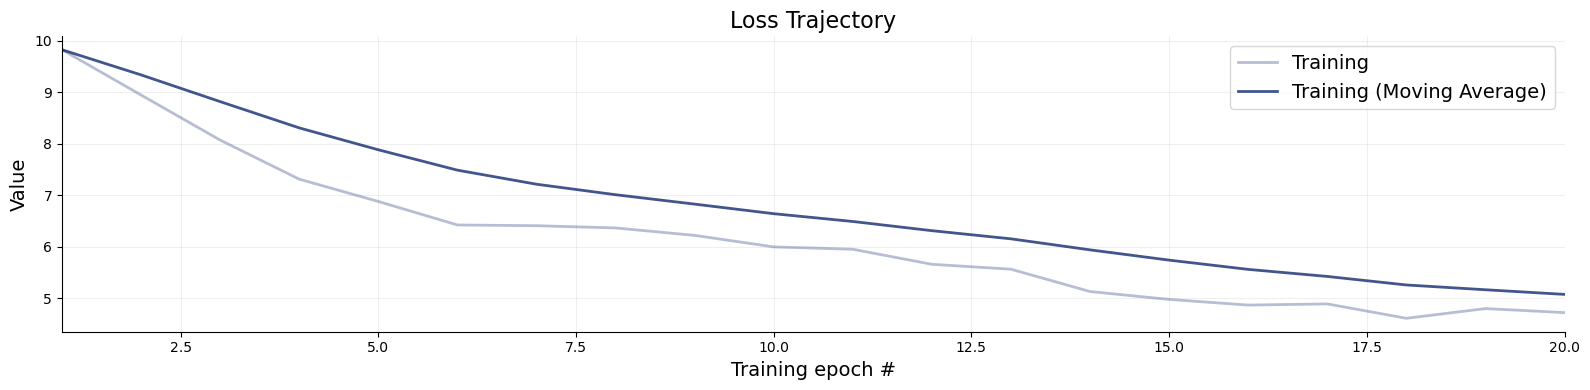

In [21]:
f = bf.diagnostics.plots.loss(history2)

In [22]:
validation_sims = validation_sims.copy()
validation_sims["num_trials"] = 120

{'losses': <Figure size 1500x300 with 1 Axes>,
 'recovery': <Figure size 1500x600 with 7 Axes>,
 'calibration_ecdf': <Figure size 1500x600 with 7 Axes>,
 'z_score_contraction': <Figure size 1500x600 with 7 Axes>}

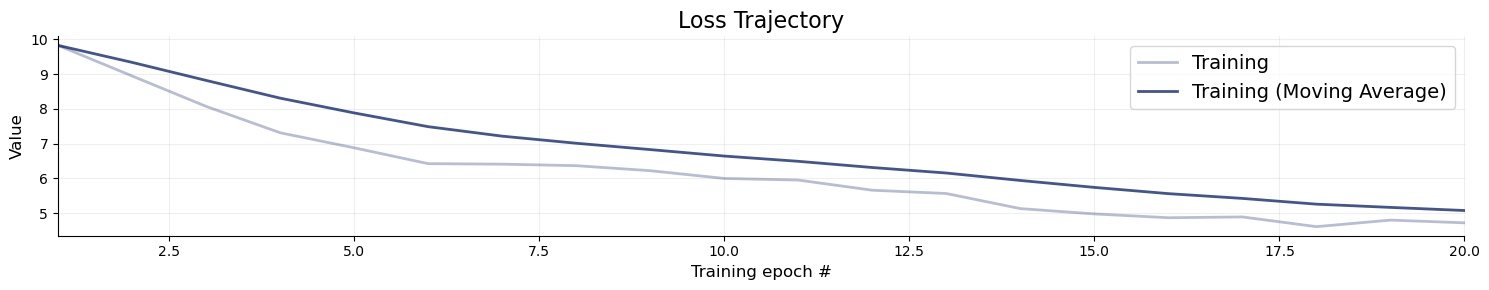

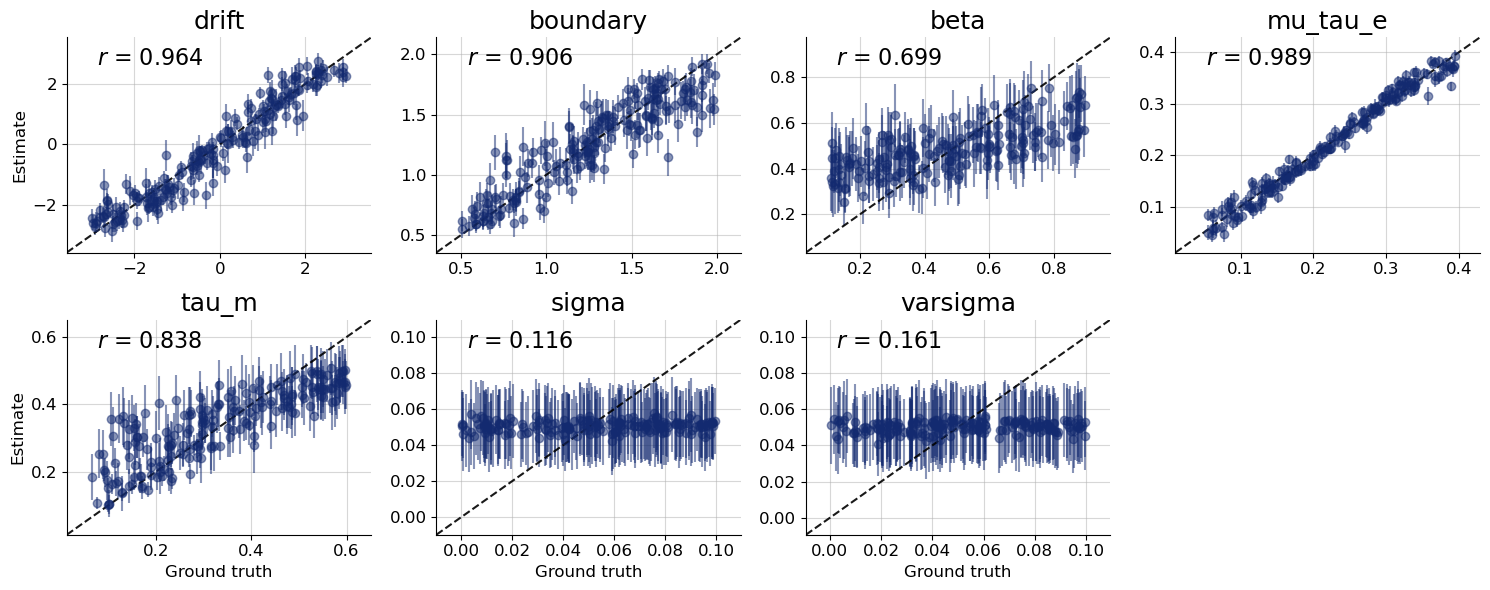

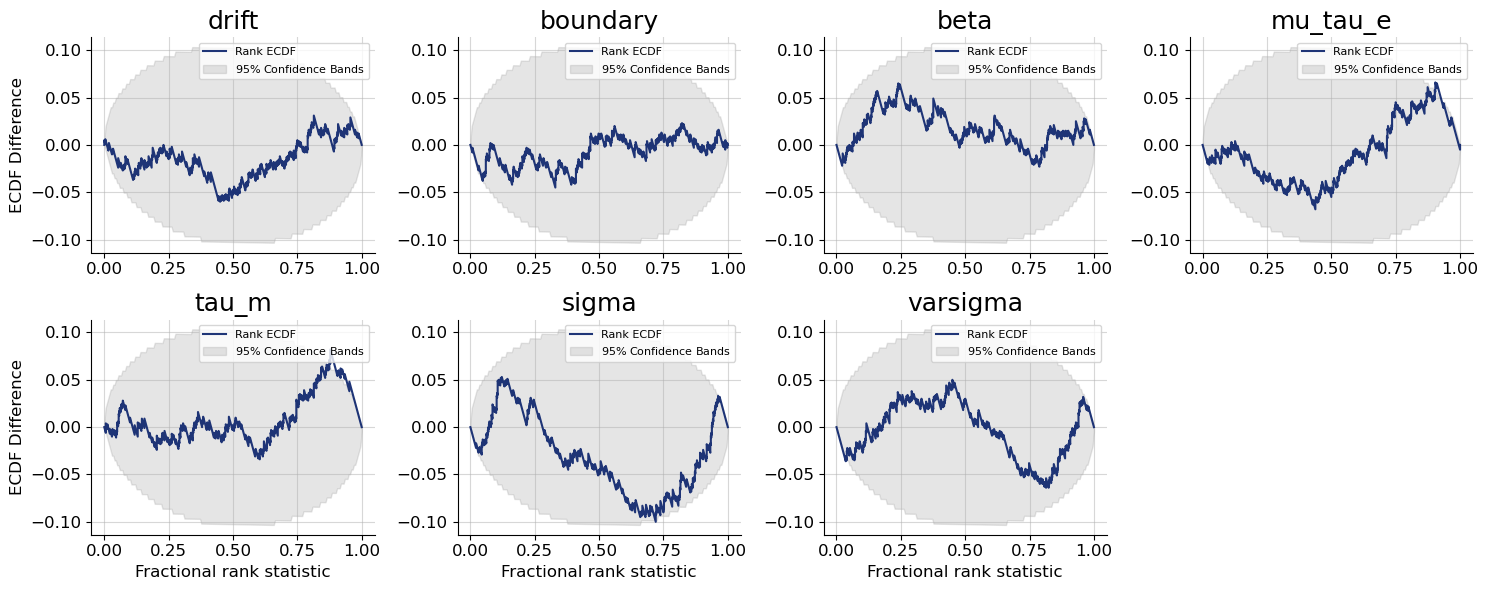

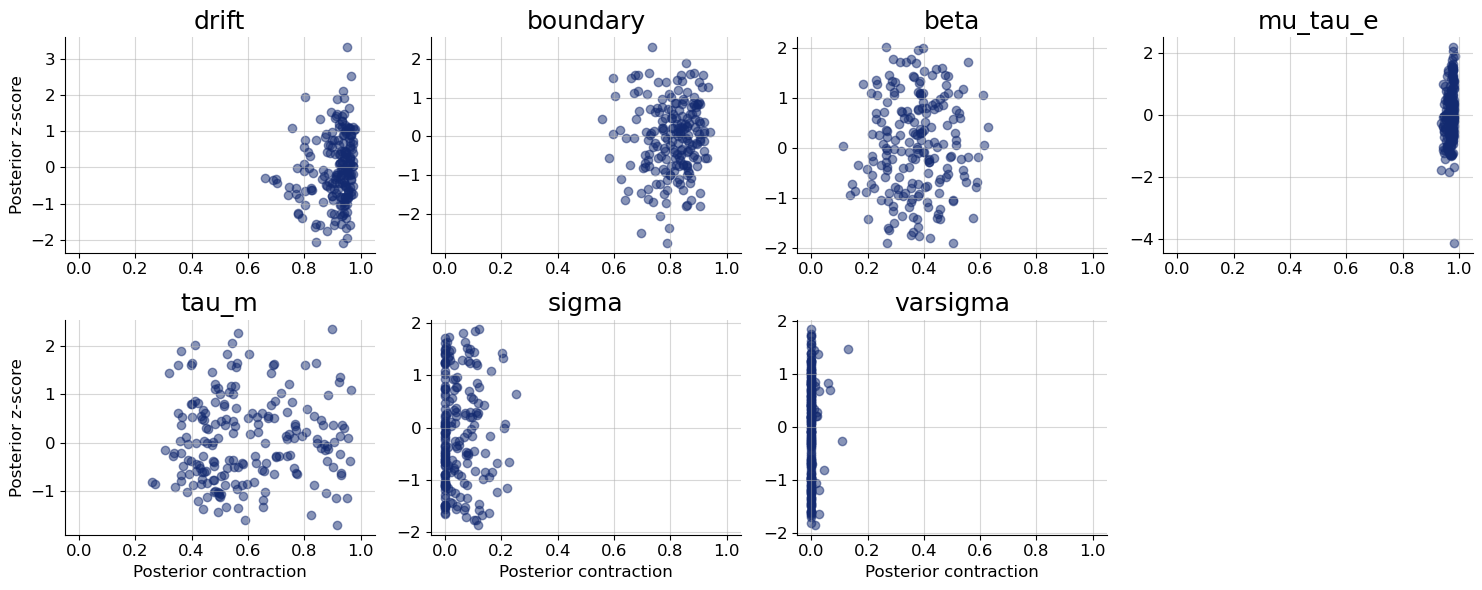

In [23]:
fig = var_trials_workflow.plot_default_diagnostics(
    test_data=validation_sims, 
    num_samples=500,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 6), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 6), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 6), "label_fontsize": 12}  
)
fig

In both settings, we can see that we are able to learn something about the first five parameters. The performance is limited by the number of epochs used in the notebook. To test the limits, increase the number of epochs and the number of training datasets. The transformer architecture used in the summary networks is quite computationally heavy, but can be efficiently parallelized by a GPU, so using a GPU will significantly speed up training.